In [7]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import copy

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from collections import OrderedDict
import shutil 

In [8]:
# Move images so that dataloader can handle it
class_maps = OrderedDict()
with open('./data/tiny-imagenet-200/val/val_annotations.txt', "r") as f:
    for line in f:
        one_line = line.split()
        class_maps[one_line[0]] = one_line[1]
# print(class_maps)

val_path = './data/tiny-imagenet-200/val/'
for image, class_name in class_maps.items():
    if not os.path.exists(val_path+'{}'.format(class_name)):
        try:
            os.makedirs(val_path+'{}/images'.format(class_name))
        except OSError as e:
            raise e
    if os.path.exists(val_path+'images'):
        source = val_path + 'images/{}'.format(image)
        destination = val_path + '{}/images/'.format(class_name)
        shutil.move(source, destination)

# remove the original image directory
if os.path.exists(val_path+'images'):
    os.rmdir(val_path + 'images')

In [9]:
# Load the Data
data_dir = './data/tiny-imagenet-200'
num_classes = 200

# Create the training data generator
batch_size = 500
im_height = 64
im_width = 64

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
}

phases = ['train', 'val', 'test']


# subset_indices = np.random.permutation(range(100))
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, 
#                              sampler=SubsetRandomSampler(subset_indices)) for x in phases}

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
              'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
              'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataloaders['train'])
print(dataset_sizes)

{'train': 100000, 'val': 10000, 'test': 10000}


In [4]:
# for inputs, labels in dataloaders['val']:
#     print(labels)
#     break

In [10]:
def plot_result(x_scale, tr, val, title, y_label):
    plt.title(title)
    if title == 'loss':
        plt.plot(x_scale, tr, label='training loss')
        plt.plot(x_scale, val, label='validation loss')
    else:
        plt.plot(x_scale, tr, label='training accuracy')
        plt.plot(x_scale, val, label='validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tr_acc.append(epoch_acc)
                tr_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_acc, val_acc, tr_loss, val_loss

### Resnet18

In [5]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Freeze model parameters to train only the last layer. 
# Comment out this cell if you want to fine tune the whole network
for param in model.parameters():
    param.requires_grad = False

In [9]:
# Change the final layer to fit 200 classes (Transfer Learning)
num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256, num_classes),
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
# learning_rates = [0.00001, 0.0001, 0.001]
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model, tr_acc, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.6905 Acc: 0.1796
val Loss: 3.2401 Acc: 0.2418

Epoch 1/9
----------
train Loss: 2.9219 Acc: 0.3066
val Loss: 2.8574 Acc: 0.3201

Epoch 2/9
----------
train Loss: 2.5039 Acc: 0.3879
val Loss: 2.7000 Acc: 0.3709

Epoch 3/9
----------
train Loss: 2.1565 Acc: 0.4573
val Loss: 3.4735 Acc: 0.2834

Epoch 4/9
----------
train Loss: 1.8196 Acc: 0.5286
val Loss: 2.5971 Acc: 0.4002

Epoch 5/9
----------
train Loss: 0.9916 Acc: 0.7257
val Loss: 2.9134 Acc: 0.4372

Epoch 6/9
----------
train Loss: 0.7121 Acc: 0.7957
val Loss: 2.9663 Acc: 0.4410

Epoch 7/9
----------
train Loss: 0.5288 Acc: 0.8430
val Loss: 3.3291 Acc: 0.4246

Epoch 8/9
----------
train Loss: 0.3894 Acc: 0.8826
val Loss: 3.8035 Acc: 0.4209

Epoch 9/9
----------
train Loss: 0.2846 Acc: 0.9127
val Loss: 4.1252 Acc: 0.4147

Training complete in 70m 31s
Best val Acc: 0.441000


In [30]:
torch.save(model, './models/resnet18_model.pt')

### Resnet152

In [ ]:
learning_rates = [1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/resnet152_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

### VGG11_bn model

In [18]:
vgg_model = models.vgg11_bn(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
vgg_model.eval()
# for param in vgg_model.parameters():
#     print(param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

learning rate: 0.0001
Epoch 0/9
----------
train Loss: 4.0349 Acc: 0.2152
val Loss: 3.2275 Acc: 0.3574

Epoch 1/9
----------
train Loss: 3.0010 Acc: 0.3564
val Loss: 2.8061 Acc: 0.3923

Epoch 2/9
----------
train Loss: 2.7291 Acc: 0.3848
val Loss: 2.6534 Acc: 0.4025

Epoch 3/9
----------
train Loss: 2.5984 Acc: 0.4021
val Loss: 2.5703 Acc: 0.4144

Epoch 4/9
----------
train Loss: 2.5161 Acc: 0.4144
val Loss: 2.5142 Acc: 0.4181

Epoch 5/9
----------
train Loss: 2.4547 Acc: 0.4239
val Loss: 2.4811 Acc: 0.4239

Epoch 6/9
----------
train Loss: 2.4075 Acc: 0.4315
val Loss: 2.4521 Acc: 0.4241

Epoch 7/9
----------
train Loss: 2.3653 Acc: 0.4408
val Loss: 2.4538 Acc: 0.4253

Epoch 8/9
----------
train Loss: 2.3594 Acc: 0.4413
val Loss: 2.4504 Acc: 0.4262

Epoch 9/9
----------
train Loss: 2.3537 Acc: 0.4419
val Loss: 2.4463 Acc: 0.4266

Training complete in 56m 8s
Best val Acc: 0.426600


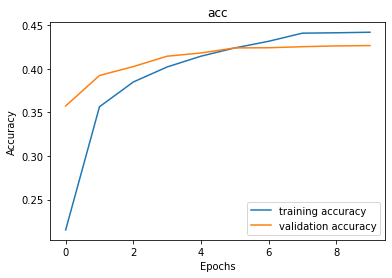

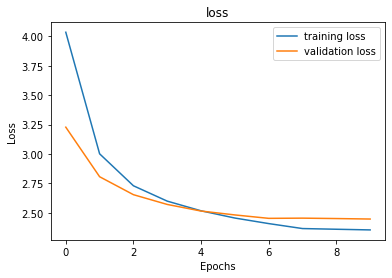


learning rate: 0.001
Epoch 0/9
----------
train Loss: 2.9334 Acc: 0.3426
val Loss: 2.4772 Acc: 0.4166

Epoch 1/9
----------
train Loss: 2.4910 Acc: 0.4117
val Loss: 2.4322 Acc: 0.4273

Epoch 2/9
----------
train Loss: 2.3819 Acc: 0.4297
val Loss: 2.4162 Acc: 0.4315

Epoch 3/9
----------
train Loss: 2.3166 Acc: 0.4406
val Loss: 2.4037 Acc: 0.4366

Epoch 4/9
----------
train Loss: 2.2732 Acc: 0.4496
val Loss: 2.3888 Acc: 0.4379

Epoch 5/9
----------
train Loss: 2.2419 Acc: 0.4539
val Loss: 2.4081 Acc: 0.4370

Epoch 6/9
----------
train Loss: 2.2160 Acc: 0.4584
val Loss: 2.4178 Acc: 0.4409

Epoch 7/9
----------
train Loss: 2.0463 Acc: 0.4885
val Loss: 2.3615 Acc: 0.4467

Epoch 8/9
----------
train Loss: 2.0154 Acc: 0.4942
val Loss: 2.3488 Acc: 0.4481

Epoch 9/9
----------
train Loss: 2.0082 Acc: 0.4975
val Loss: 2.3436 Acc: 0.4469

Training complete in 56m 34s
Best val Acc: 0.448100


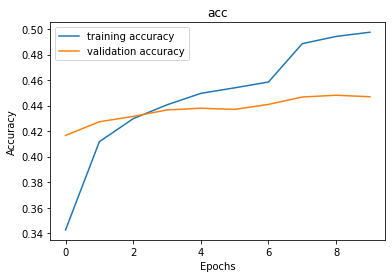

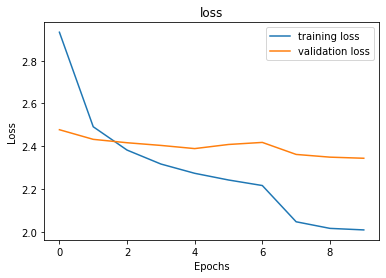


learning rate: 0.01
Epoch 0/9
----------
train Loss: 6.5293 Acc: 0.2679
val Loss: 5.3259 Acc: 0.3560

Epoch 1/9
----------
train Loss: 7.2021 Acc: 0.3117
val Loss: 6.0124 Acc: 0.3740

Epoch 2/9
----------
train Loss: 7.6590 Acc: 0.3297
val Loss: 6.3962 Acc: 0.3809

Epoch 3/9
----------
train Loss: 7.9419 Acc: 0.3405
val Loss: 6.8450 Acc: 0.3782

Epoch 4/9
----------
train Loss: 8.1958 Acc: 0.3471
val Loss: 7.2411 Acc: 0.3853

Epoch 5/9
----------
train Loss: 8.4046 Acc: 0.3525
val Loss: 7.3723 Acc: 0.3901

Epoch 6/9
----------
train Loss: 8.5217 Acc: 0.3611
val Loss: 7.4077 Acc: 0.3918

Epoch 7/9
----------
train Loss: 7.0595 Acc: 0.4048
val Loss: 6.3005 Acc: 0.4229

Epoch 8/9
----------
train Loss: 6.4815 Acc: 0.4163
val Loss: 6.0394 Acc: 0.4302

Epoch 9/9
----------
train Loss: 6.2334 Acc: 0.4185
val Loss: 5.8579 Acc: 0.4325

Training complete in 56m 48s
Best val Acc: 0.432500
train Loss: 60.9892 Acc: 0.2474
val Loss: 49.5724 Acc: 0.3482

Epoch 1/9
----------
train Loss: 69.6755 Acc

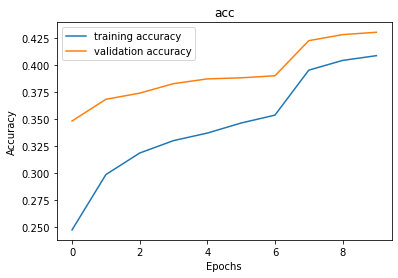

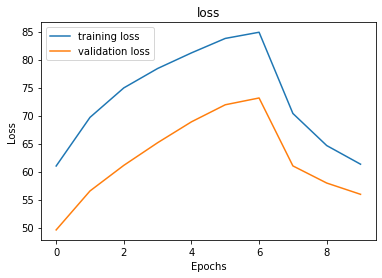


best validation accuracy tensor(0.4481, device='cuda:0', dtype=torch.float64)


In [19]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    vgg_model = models.vgg11_bn(pretrained=True)
    for param in vgg_model.parameters():
        param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model, './models/vgg11_bn_best_model.pt')
print("best validation accuracy", max_acc)

### squeezenet

In [ ]:
inc_model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)
inc_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
inc_model.eval()

In [7]:
inc_model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)
inc_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
inc_model.eval()

Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.5.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
inc_model = inc_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(inc_model.parameters(), lr=0.0001)
optimizer_ft = optim.SGD(inc_model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
inc_model, inc_tr_acc, inc_val_acc, inc_tr_loss, inc_val_loss = train_model(inc_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


### densenet

In [8]:
dense_model = torchvision.models.densenet169(pretrained=True)

In [9]:
for param in dense_model.parameters():
    param.requires_grad = False
num_ftrs = dense_model.classifier.in_features
dense_model.classifier = nn.Linear(num_ftrs, num_classes)
dense_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
dense_model = dense_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, dense_model.parameters()), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
dense_model, tr_acc, val_acc, tr_loss, val_loss = train_model(dense_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.2805 Acc: 0.3267
val Loss: 2.6901 Acc: 0.4112

Epoch 1/9
----------
train Loss: 2.3874 Acc: 0.4598
val Loss: 2.5411 Acc: 0.4316

Epoch 2/9
----------
train Loss: 2.1652 Acc: 0.4975
val Loss: 2.5113 Acc: 0.4321

Epoch 3/9
----------
train Loss: 2.0360 Acc: 0.5205
val Loss: 2.5251 Acc: 0.4307

Epoch 4/9
----------
train Loss: 1.9467 Acc: 0.5365
val Loss: 2.5328 Acc: 0.4309

Epoch 5/9
----------
train Loss: 1.8799 Acc: 0.5475
val Loss: 2.5435 Acc: 0.4301

Epoch 6/9
----------
train Loss: 1.8294 Acc: 0.5586
val Loss: 2.5770 Acc: 0.4260

Epoch 7/9
----------
train Loss: 1.6832 Acc: 0.5946
val Loss: 2.5414 Acc: 0.4330

Epoch 8/9
----------
train Loss: 1.6717 Acc: 0.5981
val Loss: 2.5461 Acc: 0.4327

Epoch 9/9
----------
train Loss: 1.6669 Acc: 0.5984
val Loss: 2.5485 Acc: 0.4332

Training complete in 56m 22s
Best val Acc: 0.433200


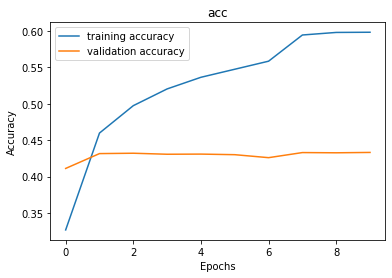

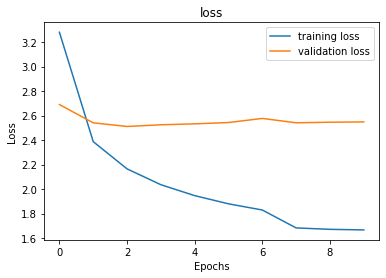

In [11]:
torch.save(dense_model.state_dict(), './models/dense169_model_state_dict.pt')
plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')